# Stochastic Optimization Example

We use the following model to generate synthetic stochastic optimization updates that transition from a transient phase to a stationary phase.

$$
x_t = x_* + a(t)\,v + z_t,
\quad
a(t)=\left(\frac{t_0}{t+t_0}\right)^\alpha,
\quad
z_t = \rho z_{t-1} + \sigma\,\epsilon_t,\ 
\epsilon_t\sim\mathcal{N}(0,I).
$$

Here, $x_*$ denotes the optimum point of the optimization, while the term $a(t)\,v$ captures the non-stationary transient phase, with $t_0$ and $\alpha$ controlling how quickly the iterates approach stationarity. The stochastic component $z_t$ models the osillations around the optimum $x_*$ through an AR(1) process, where $\rho$ controls the autocorrelation and $\sigma$ controls the noise scale.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import seaborn as sns
import warnings
from swasd import swasd
import nest_asyncio

nest_asyncio.apply()
warnings.simplefilter("ignore")
np.set_printoptions(precision=3, suppress=True)


In [3]:
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2})
sns.set_palette('colorblind', n_colors=30)
sns.set_style("ticks", {"axes.spines.right": False,
        "axes.spines.top": False})

colors = sns.color_palette("colorblind")

def swd_est_true_comparison_plot(swd_est_mean,
                                 swd_true, xlog=False, ylog=False):
    plt.scatter(swd_true, swd_est_mean, color=colors[0])
    plt.plot(swd_true, swd_true, linestyle="--", color="red")
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    plt.xlabel(r"$SWD(\pi_{(i)},\pi)$")
    plt.ylabel(r"$\widehat{SWD}(\pi_{(i)},\pi)$")
    subs = np.arange(1, 10)
    plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, subs=subs, numticks=12))
    plt.xticks(rotation=45, ha="right")
    plt.show()
    plt.close()

def regression_true_vs_fitted_plot(y_true, y_pred, y_pred_uci, y_pred_lci,
                    block_pairs, xlog=True, xlabel=None, label=None
                    ):
    pairs = np.asarray(block_pairs)
    labels = [f"{i}-{j}" for i, j in pairs]
    x = np.arange(len(labels))
    
    plt.scatter(x, y_true, alpha=1, color=colors[0])
    plt.scatter(x, y_pred, alpha=1, color=colors[3], marker="x")#, label=label)
    plt.vlines(x, y_pred_lci, y_pred_uci, color=colors[3], 
                linestyle="--")
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:   
        plt.xlabel("Block Pairs")
    plt.ylabel(r"$SWD(\hat{\pi}_{(i)}, \hat{\pi}_{(j)})$")
    if xlog:
        plt.xscale("log")
    plt.yscale("log")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.title(label=label)
    plt.show()
    plt.close()

def swd_est_plot(swd_est_mean, swd_lci, 
                      swd_uci, swd_true, 
                  conv_threshld, iterations, xlog=False, ylog=False):
    plt.plot(iterations, swd_true, color=colors[0], label=r"$SWD(\pi_{(B)},\pi)$", linewidth=2)
    plt.plot(iterations, swd_est_mean, color=colors[9], linestyle="--", label=r"$\widehat{SWD}(\pi_{(B)},\pi)$")
    plt.fill_between(iterations, swd_lci, swd_uci, color=colors[9], alpha=0.25)

    plt.axhline(conv_threshld, linestyle="dashed", color="black", alpha=0.6, 
                label=r"$\varepsilon={:.2f}$".format(conv_threshld))
    plt.xticks(rotation=45, ha="right")
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Diagnostic Value")
    plt.legend(loc='upper center', 
               bbox_to_anchor=(0.5, 1.3), ncol=2, 
               frameon=False)
    plt.show()
    plt.close()

def plot_iterate_trace(X, dims=(0, 1, 2, 3, 4), k_conv=None, xlog=True):
    plt.figure()
    for j in dims:
        plt.plot(X[:, j], linewidth=1.3, label=f"dim {j}")
    if k_conv is not None:
        plt.axvline(k_conv, linestyle="--", linewidth=2, label=f"k_conv={k_conv}")
    plt.xlabel("iteration")
    plt.ylabel("value")
    if xlog:
        plt.xscale('log')
    plt.show()

In [4]:
def generate_optim_iterates_simple(
    steps: int = 200000,
    d: int = 4,
    seed: int = 0,
    *,
    x_star=None,
    t0: float = 500.0,
    alpha: float = 0.60,
    rho: float = 0.9995,
    sigma: float = 2.5e-4,
    v=None,
):
    rng = np.random.default_rng(seed)

    if x_star is None:
        x_star = np.zeros(d)
    else:
        x_star = np.asarray(x_star, float)

    if v is None:
        v = rng.normal(size=d)
        v = v / (np.linalg.norm(v) + 1e-12) * 2.0  # initial offset magnitude
    else:
        v = np.asarray(v, float)

    z = np.zeros(d)
    X = np.empty((steps, d), float)

    for t in range(steps):
        tt = t + 1
        a = (t0 / (tt + t0)) ** alpha
        z = rho * z + sigma * rng.normal(size=d)
        X[t] = x_star + a * v + z

    return X


Generate a (num_iters, num_dims) matrix of stochastic optimization iterates.

In [5]:
T = 50000
d = 5

X = generate_optim_iterates_simple(
    steps=T,
    d=d,
    seed=123,
    t0=450.0,
    alpha=0.9,
    rho=0.99,
    sigma=2.0e-4,
)

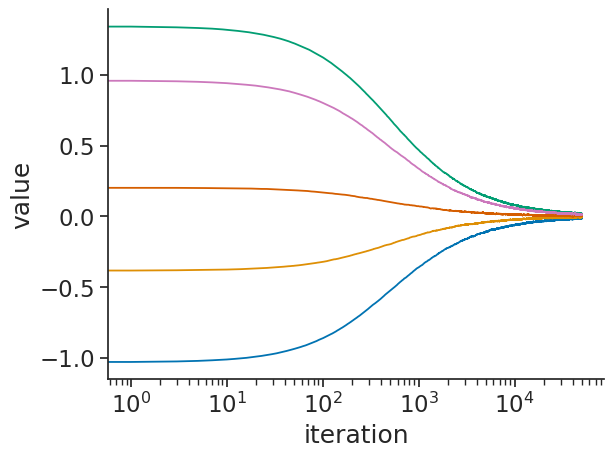

In [6]:
plot_iterate_trace(X)

We create a stationary sample to compare the estimated values of $\mathcal{SW}_{p,\Sigma}(\pi_{(i)},\pi)$, for $i=1,\ldots,B$ with the ground truth.

In [7]:
def sample_stationary_reference(n, d, x_star, rho, sigma, seed=0):
    rng = np.random.default_rng(seed)
    x_star = np.asarray(x_star, float)
    var = (sigma**2) / (1.0 - rho**2)
    return x_star[None, :] + rng.normal(size=(n, d)) * np.sqrt(var)

X_true = sample_stationary_reference(n=1000, d=d, x_star=np.zeros(d), rho=0.99, sigma=2.0e-4)

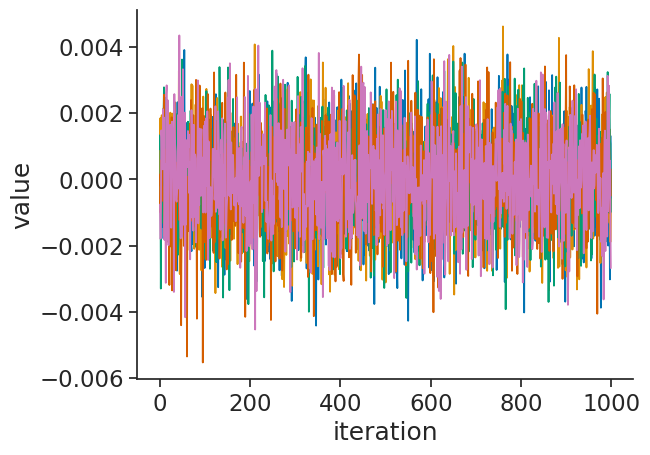

In [8]:
plot_iterate_trace(X_true, xlog=False)

Now we run the *SWASD* algorithm to detect convergence of the optimization iterates

In [9]:
algo = swasd(X,
    n_blocks=6,
    n_projections=250,
    n_bootstrap=10,
    convg_threshold=1.0,
    min_iters_per_block=250,
    block_mode="all_pairs",
    true_swd=True,
    true_samples=X_true,
    wo_init_block=True,
    diagnostic=True,
    verbose=2,
)

out = algo.run()

SWASD Convergence Detection:  95%|▉| 40/42 [19:08<00:57, 28.71s/check, k=4e+4, r


CONVERGENCE DETECTED!
Convergence at iteration: 39968
Detection method: SWD
Final SWD distance: 0.9394 (threshold: 1.0000)

Rhat checks performed: 22
Best Rhat achieved: 2.9649

SWD checks performed: 26
Initial SWD: 10.5247
Final SWD: 0.9394


In [15]:
print("--- SWASD summary ---")
print("k_conv:", out.get("k_conv"))

--- SWASD summary ---
k_conv: 39968


The *SWASD* algorithm detect convergence at $k=39,968$ iterate. 

In [16]:
convg_check_iterate = out['convg_check_iterate']
swd_pairwise_convg_results = out['pairwise_swd_results'][-1]
swd_estimated_convg_results = out['estimated_swd_results'][-1]
swd_regression_convg_results = out['regression_results'][-1]
swd_true_convg_results = out['true_swd_results'][-1]
convg_iterate_swd = convg_check_iterate[-1]

num_blocks = 6
index = num_blocks-1
y_true = swd_pairwise_convg_results["mean_all"][index:]
y_pred = np.exp(swd_regression_convg_results["y_predicted"])
y_pred_uci = np.exp(swd_regression_convg_results["upper_CI"])
y_pred_lci = np.exp(swd_regression_convg_results["lower_CI"])
block_pairs = np.array(swd_pairwise_convg_results["block_pair"])[index:]


Next we can compare the observed pairwise distances with the fitted values at the convergence check point.

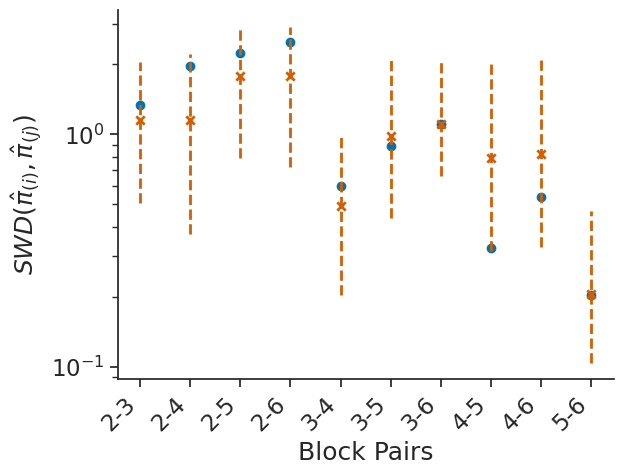

In [17]:
regression_true_vs_fitted_plot(
            y_true, y_pred,
            y_pred_uci, y_pred_lci, block_pairs,
            xlog=False)

We can also compare the true and the estimated SW distance between block distribution and stationary distribution $\mathcal{SW}_{2,\Sigma}(\pi_{(i)},\pi)$

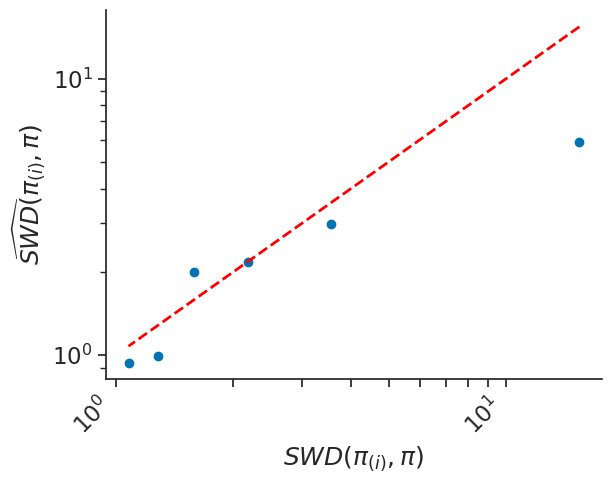

In [18]:
swd_est_mean = swd_estimated_convg_results["swd_est_mean"]
swd_true = swd_true_convg_results["mean_all"]
swd_est_true_comparison_plot(swd_est_mean, swd_true, xlog=True, ylog=True)

We can check the reliability of $\widehat{\mathcal{SW}}_{2,\Sigma}(\pi_{(i)},\pi)$ by comparing it with its true values $\mathcal{SW}_{2,\Sigma}(\pi_{(i)},\pi)$.

In [19]:
swd_est_mean_last_block = [out['estimated_swd_results'][i]["swd_est_mean"][-1] for i in range(len(convg_check_iterate))]
swd_est_median_last_block = [out['estimated_swd_results'][i]["swd_est_median"][-1] for i in range(len(convg_check_iterate))]
swd_est_lci_last_block = [out['estimated_swd_results'][i]["swd_lci"][-1] for i in range(len(convg_check_iterate))]
swd_est_uci_last_block = [out['estimated_swd_results'][i]["swd_uci"][-1] for i in range(len(convg_check_iterate))]
swd_true_last_block = [out['true_swd_results'][i]["mean_all"][-1] for i in range(len(convg_check_iterate))]

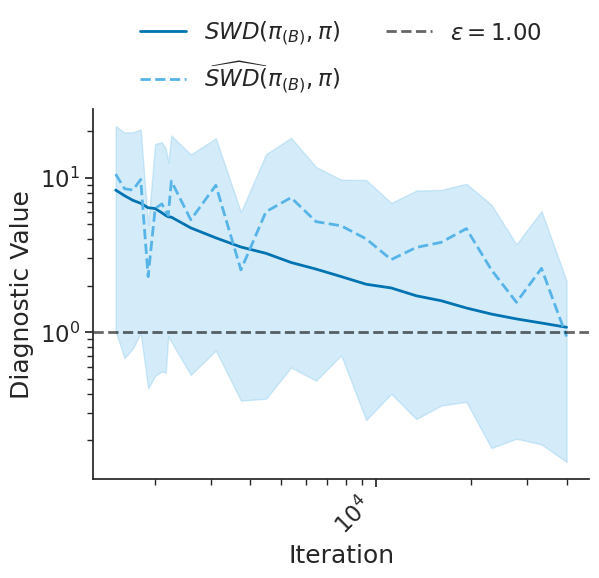

In [20]:
#plot the estimated and true SW distance between block and stationary distrubtions of the last block
swd_est_plot(swd_est_mean_last_block,
                      swd_est_lci_last_block, swd_est_uci_last_block,
                      swd_true_last_block,
                      1.0,
                      convg_check_iterate,
                      xlog=True, ylog=True)